### Baseline models and Feature Selection

In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import utils
from constants import DATA_DIR

In [2]:
np.random.seed(23)
warnings.filterwarnings("ignore")

### Simple Season Average
Baseline model - DraftKings shows season average in their data and interface

In [3]:
df_baseline = utils.csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling', 'Baseline'))
df_baseline.sort_values(by=['Date','Name']).reset_index(drop=True, inplace=True)
df_baseline['FPTS_pred'] = utils.calculate_FPTS(df_baseline)

# Season average
print(' MAE | ', utils.calculate_MAE(df_baseline['FPTS_pred'], df_baseline['FPTS']))
print('RMSE | ', utils.calculate_RMSE(df_baseline['FPTS_pred'], df_baseline['FPTS']))


 MAE |  7.472289544657329
RMSE |  9.921164051956424


In [4]:
# Linear Regression with basic 9 variables counted for fantasy points
df_baseline = df_baseline
basic =  ['PTS','3P','AST','TRB','STL','BLK','TOV', 'DD', 'TD']

X = df_baseline.loc[:, basic]
X = MinMaxScaler().fit_transform(X)
y = df_baseline['FPTS'].values.reshape(-1,1).flatten()

reg = LinearRegression()
errors = utils.cross_val(reg, X, y, n_folds=5, verbose=0)
utils.summarize_errors(errors)



   <--- Validation Errors --->
MAE  | Mean: 7.57319, SD: 0.03217
RMSE | Mean: 9.85258, SD: 0.04571



### Weighted Features
Choose weighting scheme from linear, square root and quadratic

In [5]:
features = ['SG', 'F', 'C', 'PTS', '3P', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'DD', 'TD', 'MP', 'FT',
            'FTA', 'FGA', '3PA', 'DRB', 'ORB', 'USG_perc', 'DRtg', 'ORtg', 'AST_perc', 'DRB_perc',
            'ORB_perc', 'BLK_perc', 'TOV_perc', 'STL_perc', 'eFG_perc', 'FG_perc', '3P_perc', 'FT_perc']

In [7]:
for weighting in ['sqrt', 'linear', 'quad']:
    print("\nweighting sheme:", weighting)
    df_features = utils.csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling', 'Features', weighting))  
    
    X = df_features.loc[:, features]
    X = MinMaxScaler().fit_transform(X)
    y = df_features['FPTS'].values.reshape(-1,1).flatten()

    reg = LinearRegression()
    errors = utils.cross_val(reg, X, y, n_folds=5, verbose=0)
    utils.summarize_errors(errors, verbose=0)


weighting sheme: sqrt




   <--- Validation Errors --->
MAE  | Mean: 7.33355, SD: 0.04243
RMSE | Mean: 9.61004, SD: 0.06262


weighting sheme: linear




   <--- Validation Errors --->
MAE  | Mean: 7.30567, SD: 0.04419
RMSE | Mean: 9.58473, SD: 0.06456


weighting sheme: quad




   <--- Validation Errors --->
MAE  | Mean: 7.30426, SD: 0.04765
RMSE | Mean: 9.59096, SD: 0.06601



### Feature Selection with Feature Importances

In [8]:
weighting = 'quad'
df_features = utils.csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling', 'Features', weighting))  

In [9]:
_all = ['Salary', 'Rest', 'Rota_All', 'Rota_Pos', 'Home', 'SG', 'F', 'C', 'Value', 'FPTS_std',
        'PTS', '3P', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'DD', 'TD', 'MP', 'FT', 'FTA', 'FGA', '3PA', 'DRB',
        'ORB', 'USG_perc', 'DRtg', 'ORtg', 'AST_perc', 'DRB_perc', 'ORB_perc', 'BLK_perc', 'TOV_perc', 
        'STL_perc', 'eFG_perc', 'FG_perc', '3P_perc', 'FT_perc']

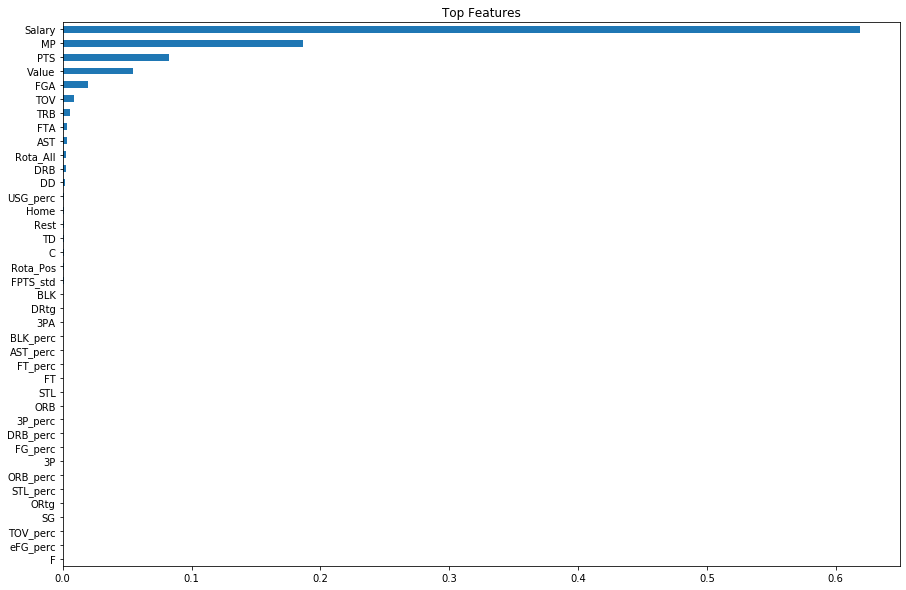

In [10]:
X = df_features.loc[:, _all]
X = MinMaxScaler().fit_transform(X)
y = df_features['FPTS'].values.reshape(-1,1).flatten()

# Takes 2 minutes
model = GradientBoostingRegressor()
model.fit(X, y)

top_features = pd.Series(model.feature_importances_, index = _all).sort_values()
top_features.plot(kind = "barh", figsize=(15,10) ,title='Top Features')
plt.show()

### Linear Regression with All / Selected Features

In [11]:
omit_lowest = 20
_selected = list(top_features[omit_lowest:].index)

In [17]:
for feature_type in [_all, _selected]:
    for weighting in ['sqrt', 'linear', 'quad']:
        df_features = utils.csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling',
                                                         'Features', weighting))
        print("\nweighting sheme: {}".format(weighting))

        X = df_features.loc[:, feature_type]
        X = MinMaxScaler().fit_transform(X)
        y = df_features['FPTS'].values.reshape(-1,1).flatten()
        
        reg = LinearRegression()

        errors = utils.cross_val(reg, X, y, verbose=0)
        utils.summarize_errors(errors, verbose=0)
        
    print("========================")


weighting sheme: sqrt




   <--- Validation Errors --->
MAE  | Mean: 7.28797, SD: 0.04126
RMSE | Mean: 9.54591, SD: 0.05979


weighting sheme: linear




   <--- Validation Errors --->
MAE  | Mean: 7.25764, SD: 0.04189
RMSE | Mean: 9.51487, SD: 0.06149


weighting sheme: quad




   <--- Validation Errors --->
MAE  | Mean: 7.2352, SD: 0.04257
RMSE | Mean: 9.49186, SD: 0.06223


weighting sheme: sqrt




   <--- Validation Errors --->
MAE  | Mean: 7.31145, SD: 0.04191
RMSE | Mean: 9.57094, SD: 0.06134


weighting sheme: linear




   <--- Validation Errors --->
MAE  | Mean: 7.28358, SD: 0.0426
RMSE | Mean: 9.54219, SD: 0.06293


weighting sheme: quad




   <--- Validation Errors --->
MAE  | Mean: 7.26486, SD: 0.0431
RMSE | Mean: 9.52171, SD: 0.06373



### Season Average Baseline
- MAE - 7.47229
- RMSE - 9.92116

### Linear Regression with Additional Features and Quadratic Weighting
- MAE  | Mean: 7.2352, SD: 0.04257
- RMSE | Mean: 9.49186, SD: 0.06223
